In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key=os.getenv("ALPACA_API_KEY")
alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
alpaca=tradeapi.REST(alpaca_api_key,alpaca_secret_key,api_version="v2")

In [4]:
# Set start and end dates of 3 years back from your current date
# Alternatively, you can use an end date of 2020-08-07 and work 3 years back from that date 
import datetime as dt
from pandas.tseries.offsets import DateOffset

today= dt.date.today() #- DateOffset(days=1)
start= today - DateOffset(years=5)

start_date=start.date()

timeframe='1Day'

print(start_date, end_date)

2018-03-21 2023-03-21


In [8]:
tickers = ["AAPL", "TSLA", "MSFT"] #this will be gathered from sidebar eventually

tickers_dfs = []

timeframe = "1Day"

df_portfolio_year = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date
).df

#Reformatting the index
df_portfolio_year.index=pd.to_datetime(df_portfolio_year.index).date

df_portfolio_year

,open,high,low,close,volume,trade_count,vwap,symbol
2018-03-21,175.040,175.0900,171.26,171.270,37055152,238351,173.087620,AAPL
2018-03-22,170.000,172.6800,168.60,168.845,41493879,289764,170.196940,AAPL
2018-03-23,168.390,169.9200,164.94,164.940,41028966,284670,167.548254,AAPL
2018-03-26,168.060,173.1000,166.44,172.770,37541736,232077,170.050591,AAPL
2018-03-27,173.680,175.1500,166.92,168.340,40923385,276951,171.395108,AAPL
...,...,...,...,...,...,...,...,...
2023-03-15,180.800,182.3400,176.03,180.450,146163423,1285658,179.391062,TSLA
2023-03-16,180.365,185.8100,178.84,184.130,121384652,1120980,182.917437,TSLA
2023-03-17,184.515,186.2199,177.33,180.130,134006952,1169025,180.459150,TSLA
2023-03-20,178.080,186.4400,176.35,183.250,129790178,1175261,182.885668,TSLA


## Creating data for signals

In [31]:
import hvplot.pandas
# Import the finta Python library and the TA module
from finta import TA
import numpy as np

In [28]:
step1=df_portfolio_year.loc[df_portfolio_year['symbol']==tickers[0]].copy()
display(step1.head())

# Create additional technical indicators
step1["ssma"] = TA.SSMA(step1)
step1["ema"] = TA.EMA(step1, 50)
step1["dema"] = TA.DEMA(step1)
step1["tema"] = TA.TEMA(step1)
step1["trima"] = TA.TRIMA(step1)
step1["sma"] = TA.TRIMA(step1)
step1["trima"] = TA.TRIMA(step1)
step1['sma_fast'] = TA.SMA(step1, 50)
step1['sma_slow'] = TA.SMA(step1, 100)

step1[['close','ssma','dema','tema','trima','sma_fast','sma_slow']].hvplot()

,open,high,low,close,volume,trade_count,vwap,symbol
2018-03-21,175.04,175.09,171.26,171.270,37055152,238351,173.087620,AAPL
2018-03-22,170.00,172.68,168.60,168.845,41493879,289764,170.196940,AAPL
2018-03-23,168.39,169.92,164.94,164.940,41028966,284670,167.548254,AAPL
2018-03-26,168.06,173.10,166.44,172.770,37541736,232077,170.050591,AAPL
2018-03-27,173.68,175.15,166.92,168.340,40923385,276951,171.395108,AAPL


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [51]:
# Filter the date index and close columns
# Use the pct_change function to generate  returns from close prices
# Drop all NaN values from the DataFrame

signals_df=step1.loc[:,["close",'ssma','ema','dema','tema','trima','sma_slow','sma_fast']]

signals_df['actual_returns']=signals_df['close'].pct_change()

signals_df=signals_df.dropna()

display(signals_df.head())
display(signals_df.tail())

,close,ssma,ema,dema,tema,trima,sma_slow,sma_fast,actual_returns
2018-08-10,207.53,200.932889,193.604152,209.481058,209.937241,192.041698,184.43175,192.2878,-0.006463
2018-08-13,208.87,201.814796,194.213530,210.001363,210.140037,192.717500,184.80775,192.6604,0.006457
2018-08-14,209.75,202.696491,194.833276,210.605904,210.545662,193.426975,185.21680,193.0188,0.004213
2018-08-15,210.24,203.534663,195.447433,211.134973,210.907785,194.165864,185.66980,193.3574,0.002336
2018-08-16,213.32,204.621928,196.159424,212.546579,212.519513,194.949599,186.07530,193.7442,0.014650


,close,ssma,ema,dema,tema,trima,sma_slow,sma_fast,actual_returns
2023-03-15,152.99,150.434087,147.196492,151.988877,152.388929,150.475802,143.9347,144.7934,0.002621
2023-03-16,155.85,151.035855,147.535845,153.513488,154.300832,150.481235,144.0593,145.4090,0.018694
2023-03-17,155.00,151.476315,147.828557,154.276699,155.051235,150.486358,144.1366,145.9818,-0.005454
2023-03-20,157.40,152.134503,148.203908,155.658086,156.626098,150.502407,144.2161,146.6294,0.015484
2023-03-21,159.28,152.928447,148.638264,157.288651,158.461330,150.538241,144.2855,147.2226,0.011944


## Creating trading signals

In [52]:
signals_df['Signal']=np.where(signals_df['actual_returns']>=0 ,1 ,-1)

signals_df[['Signal','actual_returns']].groupby('Signal').describe()

actual_returns                                                    \
                count      mean       std       min       25%       50%   
Signal                                                                    
-1              539.0 -0.016643  0.034882 -0.741522 -0.020959 -0.010605   
 1              621.0  0.015425  0.014721  0.000000  0.005427  0.012270   

                            
             75%       max  
Signal                      
-1     -0.004595 -0.000094  
 1      0.021074  0.119808

<AxesSubplot:>

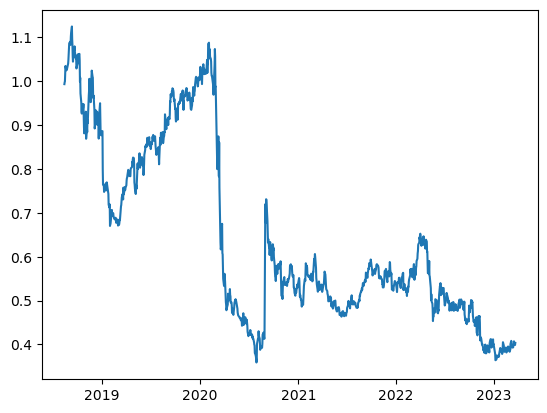

In [53]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['actual_returns'] * signals_df['Signal'].shift()

# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

## Setting up data for modeling

In [54]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

y.value_counts()

 1    621
-1    539
Name: Signal, dtype: int64

In [55]:
X=signals_df[['close','ssma','ema','dema','tema','trima','sma_slow','sma_fast']].shift().dropna()

X

,close,ssma,ema,dema,tema,trima,sma_slow,sma_fast
2018-08-13,207.53,200.932889,193.604152,209.481058,209.937241,192.041698,184.43175,192.2878
2018-08-14,208.87,201.814796,194.213530,210.001363,210.140037,192.717500,184.80775,192.6604
2018-08-15,209.75,202.696491,194.833276,210.605904,210.545662,193.426975,185.21680,193.0188
2018-08-16,210.24,203.534663,195.447433,211.134973,210.907785,194.165864,185.66980,193.3574
2018-08-17,213.32,204.621928,196.159424,212.546579,212.519513,194.949599,186.07530,193.7442
...,...,...,...,...,...,...,...,...
2023-03-15,152.59,150.114597,146.960022,151.277993,151.527778,150.449630,143.84340,144.3322
2023-03-16,152.99,150.434087,147.196492,151.988877,152.388929,150.475802,143.93470,144.7934
2023-03-17,155.85,151.035855,147.535845,153.513488,154.300832,150.481235,144.05930,145.4090
2023-03-20,155.00,151.476315,147.828557,154.276699,155.051235,150.486358,144.13660,145.9818


## Creating training and testing datasets

In [56]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end.date())

2018-08-13
2019-02-13


In [57]:
# Generate the X_train and y_train DataFrames

X_train=X.loc[training_begin:training_end]
y_train=y.loc[training_begin:training_end]

X_test=X.loc[training_end+DateOffset(days=1):]
y_test=y.loc[training_end+DateOffset(days=1):]

display(y_train.value_counts())
display(y_test.value_counts())

C:\Users\kunal\anaconda3\envs\dev\lib\site-packages\pandas\core\indexes\base.py:3361: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)
C:\Users\kunal\anaconda3\envs\dev\lib\site-packages\pandas\core\algorithms.py:1601: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return arr.searchsorted(value, side=side, sorter=sorter)


 1    68
-1    59
Name: Signal, dtype: int64

 1    553
-1    479
Name: Signal, dtype: int64

## Prediction using SVM

In [59]:
#import for scaling data
from sklearn.preprocessing import StandardScaler 

#import for support vector machines
from sklearn.svm import SVC

#imports for model performance metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [60]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [61]:
#Create a model
svc_model=SVC()

svc_model

#Fit a model

svc_model=svc_model.fit(X_train_scaled,y_train)

#Predict based on the model using training data
y_train_predict=svc_model.predict(X_train_scaled)

y_train_predict

# Use the testing data to make the model predictions
svc_pred = svc_model.predict(X_test_scaled)

svc_pred

array([1, 1, 1, ..., 1, 1, 1])

In [62]:
# Score the accuracy
print(f"Training Data Score: {svc_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {svc_model.score(X_test_scaled, y_test)}")

Training Data Score: 0.6062992125984252
Testing Data Score: 0.5251937984496124


In [63]:
# Create a confusion matrix
print(confusion_matrix(y_test, svc_pred))

# Print the classification report
print(classification_report(y_test, svc_pred))

# # Create a confusion matrix
# print(confusion_matrix(y_train, svc_model.predict(X_train_scaled)))

# # Print the classification report
# print(classification_report(y_train, svc_model.predict(X_train_scaled)))

[[  6 473]
 [ 17 536]]
              precision    recall  f1-score   support

          -1       0.26      0.01      0.02       479
           1       0.53      0.97      0.69       553

    accuracy                           0.53      1032
   macro avg       0.40      0.49      0.36      1032
weighted avg       0.41      0.53      0.38      1032



In [64]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted Signals'] = svc_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['actual_returns'].loc[training_end+DateOffset(hours=1):]

# Add the actual returns to the DataFrame
predictions_df['Signal'] = signals_df['Signal'].loc[training_end+DateOffset(hours=1):]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['actual_returns']*predictions_df['Predicted Signals']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())
display(predictions_df.shape)
display(predictions_df[['Predicted Signals','Signal']].value_counts())
display(predictions_df['Actual Returns'].mean())

C:\Users\kunal\anaconda3\envs\dev\lib\site-packages\pandas\core\indexes\base.py:3361: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)
C:\Users\kunal\anaconda3\envs\dev\lib\site-packages\pandas\core\algorithms.py:1601: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return arr.searchsorted(value, side=side, sorter=sorter)


,Predicted Signals,Actual Returns,Signal,Strategy Returns
2019-02-14,1,0.003643,1,0.003643
2019-02-15,1,-0.002225,-1,-0.002225
2019-02-19,1,0.002993,1,0.002993
2019-02-20,1,0.006435,1,0.006435
2019-02-21,1,-0.005639,-1,-0.005639


,Predicted Signals,Actual Returns,Signal,Strategy Returns
2023-03-15,1,0.002621,1,0.002621
2023-03-16,1,0.018694,1,0.018694
2023-03-17,1,-0.005454,-1,-0.005454
2023-03-20,1,0.015484,1,0.015484
2023-03-21,1,0.011944,1,0.011944


(1032, 4)

Predicted Signals  Signal
 1                  1        536
                   -1        473
-1                  1         17
                   -1          6
dtype: int64

0.0007546640886643549

<AxesSubplot:title={'center':'Model Performance: Support Vector Machine Classifier'}>

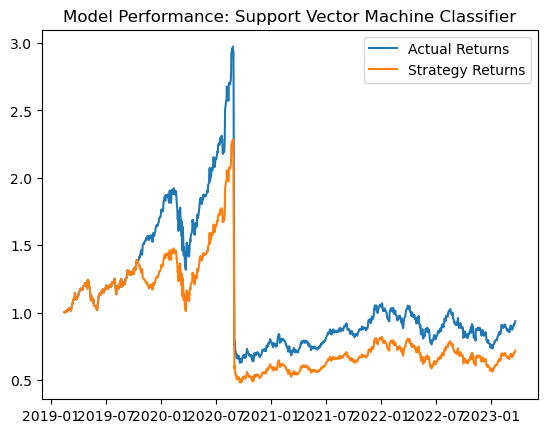

In [65]:
# Plot the actual returns versus the strategy returns

(1+predictions_df[['Actual Returns','Strategy Returns']]).cumprod().plot(title="Model Performance: Support Vector Machine Classifier")

## Prediction using decision tree

In [66]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# Initiate the model instance
model_tree=tree.DecisionTreeClassifier()

model_tree=model_tree.fit(X_train_scaled,y_train)

predict_test=model_tree.predict(X_test_scaled)

In [67]:
# Use a classification report to evaluate the model using the predictions and testing data
print(classification_report(y_test, predict_test))

              precision    recall  f1-score   support

          -1       0.44      0.29      0.35       479
           1       0.53      0.69      0.60       553

    accuracy                           0.50      1032
   macro avg       0.48      0.49      0.47      1032
weighted avg       0.49      0.50      0.48      1032



## Predict using Logistic

In [70]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# Initiate the model instance
model_logistic=LogisticRegression()

# Fit the model using the training data
model_logistic = model_logistic.fit(X_train_scaled,y_train)

# Use the testing dataset to generate the predictions for the new model
pred_test = model_logistic.predict(X_test_scaled)

# Review the model's predicted values
pred_test

array([1, 1, 1, ..., 1, 1, 1])

In [71]:
# Use a classification report to evaluate the model using the predictions and testing data
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

          -1       0.44      0.30      0.35       479
           1       0.52      0.67      0.59       553

    accuracy                           0.50      1032
   macro avg       0.48      0.48      0.47      1032
weighted avg       0.48      0.50      0.48      1032

